<a href="https://colab.research.google.com/github/lopez-hector/ControlNet/blob/main/ControlNet_HLH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!which python
!python --version

Mounted at /content/drive
/usr/local/bin/python
Python 3.9.16


論文<br>
<br>
<br>
GitHub<br>
https://github.com/lllyasviel/ControlNet<br>
<br>
<a href="https://colab.research.google.com/github/kaz12tech/ai_demos/blob/master/ControlNet_demo.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup environment

## check GPU

In [ ]:
!nvidia-smi

Fri Mar 10 00:11:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## clone code from Github

In [ ]:
import os
%cd /content/drive/MyDrive

if not os.path.exists('/content/drive/MyDrive/ControlNet'):
  !git clone https://github.com/lllyasviel/ControlNet.git

%cd /content/drive/MyDrive/ControlNet

/content/drive/MyDrive/ControlNet
^C


## install libraries

In [ ]:
%cd /content/drive/MyDrive/ControlNet

!pip uninstall torch torchtext -y
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1
!pip install omegaconf==2.1.1 einops==0.3.0
!pip install pytorch-lightning==1.5.0
!pip install transformers==4.19.2 open_clip_torch==2.0.2

## import library

In [ ]:
%cd /content/drive/MyDrive/ControlNet

import numpy as np
from PIL import Image as PilImage
import einops
import matplotlib.pyplot as plt

from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

import torch
from pytorch_lightning import seed_everything

from cldm.model import create_model, load_state_dict
from ldm.models.diffusion.ddim import DDIMSampler

from annotator.util import resize_image, HWC3

/content/drive/MyDrive/ControlNet


# Get models and Annotations from HF Hub

In [18]:
%cd /content/drive/MyDrive/ControlNet

models_annotations = ['/models/control_sd15_scribble.pth',
                      '/models/control_sd15_openpose.pth',
                      '/annotator/ckpts/body_pose_model.pth',
                      '/annotator/ckpts/hand_pose_model.pth',
                      '/models/control_sd15_depth.pth']

# download model from huggingface
for item in models_annotations:
  if not os.path.exists('.'+item):
    print(f'Downloading: {item}')
    !wget -c https://huggingface.co/lllyasviel/ControlNet/resolve/main$item \
          -O .$item

/content/drive/MyDrive/ControlNet
Downloading: /models/control_sd15_depth.pth
--2023-03-10 05:59:14--  https://huggingface.co/lllyasviel/ControlNet/resolve/main/models/control_sd15_depth.pth
Resolving huggingface.co (huggingface.co)... 54.235.118.239, 3.231.67.228, 2600:1f18:147f:e850:e203:c458:10cd:fc3c, ...
Connecting to huggingface.co (huggingface.co)|54.235.118.239|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/f6/65/f665e553e8fd16131981a96c629e785939f08080bb3cbf8d2b7f5ddbd9e6100a/726cd0b472c4b5c0341b01afcb7fdc4a7b4ab7c37fe797fd394c9805cbef60bf?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27control_sd15_depth.pth%3B+filename%3D%22control_sd15_depth.pth%22%3B&Expires=1678686969&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2Y2LzY1L2Y2NjVlNTUzZThmZDE2MTMxOTgxYTk2YzYyOWU3ODU5MzlmMDgwODBiYjNjYmY4ZDJiN2Y1ZGRiZDllNjEwMGEvNzI2Y2QwYjQ3MmM0YjVjMDM0MWIwMWFmY2I

# Set up model

In [ ]:
%cd /content/drive/MyDrive/ControlNet

model = create_model('./models/cldm_v15.yaml')
model.load_state_dict(load_state_dict('./models/control_sd15_openpose.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

/content/drive/MyDrive/ControlNet
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.mlp.fc2.bias', 'vision_model.encoder.layers.1.layer_norm2.weight', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.self_attn.q_proj.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.15.mlp.fc2.weight', 'vision_model.encoder.layers.5.mlp.fc1.weight', 'vision_model.encoder.layers.21.layer_norm1.weight', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.21.self_attn.q_proj.weight', 'vision_model.encoder.layers.14.layer_norm2.weight', 'visual_projection.weight', 'vision_model.encoder.layers.3.layer_norm1.bias', 'vision_model.encoder.layers.15.mlp.fc1.weight', 'vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.1.layer_norm1.weight', 'vision_model.e

Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_openpose.pth]


# setup prompt

In [ ]:
prompt = 'albert einstein looking into the distance cyberpunk' # @param {type:"string"}

In [ ]:
# active and negative prompt
a_prompt = 'best quality, extremely detailed, dslr photography'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, black and white'

# setup config

In [ ]:
image_resolution = 512
num_samples = 1
seed = 12
ddim_steps = 20
eta = 0.0
scale = 9.0

# setup image

In [25]:
img_path = '/content/drive/MyDrive/ControlNet/test_imgs/pose1.png'
PilImage.open(img_path)

<_io.TextIOWrapper name='/content/drive/MyDrive/ControlNet/test_imgs/pose1.png' mode='r' encoding='UTF-8'>

# Run Model

In [ ]:
#@title scribble inference function
def scribble_inference(img_path, prompt, a_prompt, n_prompt):
  # preprocess image
  input_img = np.array(PilImage.open(img_path))
  img = resize_image(HWC3(input_img), image_resolution)
  H, W, C = img.shape

  # initialize detect map
  detected_map = np.zeros_like(img, dtype=np.uint8)
  detected_map[np.min(img, axis=2) < 127] = 255
  control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
  control = torch.stack([control for _ in range(num_samples)], dim=0)
  control = einops.rearrange(control, 'b h w c -> b c h w').clone()

  # set random seed
  seed_everything(seed)

  # get conftioning and unconditioning
  cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
  un_cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
  shape = (4, H // 8, W // 8)

  # sampling
  samples, intermediates = ddim_sampler.sample(
      ddim_steps, num_samples,
      shape, cond, verbose=False, eta=eta,
      unconditional_guidance_scale=scale,
      unconditional_conditioning=un_cond)
  
  # post process
  x_samples = model.decode_first_stage(samples)
  x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

  results = [x_samples[i] for i in range(num_samples)]
  np_imgs = [255 - detected_map] + results

  return np_imgs

In [ ]:
#@title pose inference function
from annotator.util import resize_image, HWC3
from annotator.openpose import apply_openpose
import random
import cv2
def pose_inference(input_image, prompt, a_prompt, n_prompt):
    with torch.no_grad():
        input_img = np.array(PilImage.open(img_path))
        input_image = HWC3(input_img)
        detected_map, _ = apply_openpose(resize_image(input_image, 512))
        detected_map = HWC3(detected_map)
        img = resize_image(input_image, image_resolution)
        H, W, C = img.shape

        detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if True:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [detected_map] + results

In [ ]:
#@title Inference (PICK INFERENCE FUNCTION)
# np_imgs = scribble_inference(img_path, prompt, a_prompt, n_prompt)
np_imgs = pose_inference(img_path, prompt, a_prompt, n_prompt)

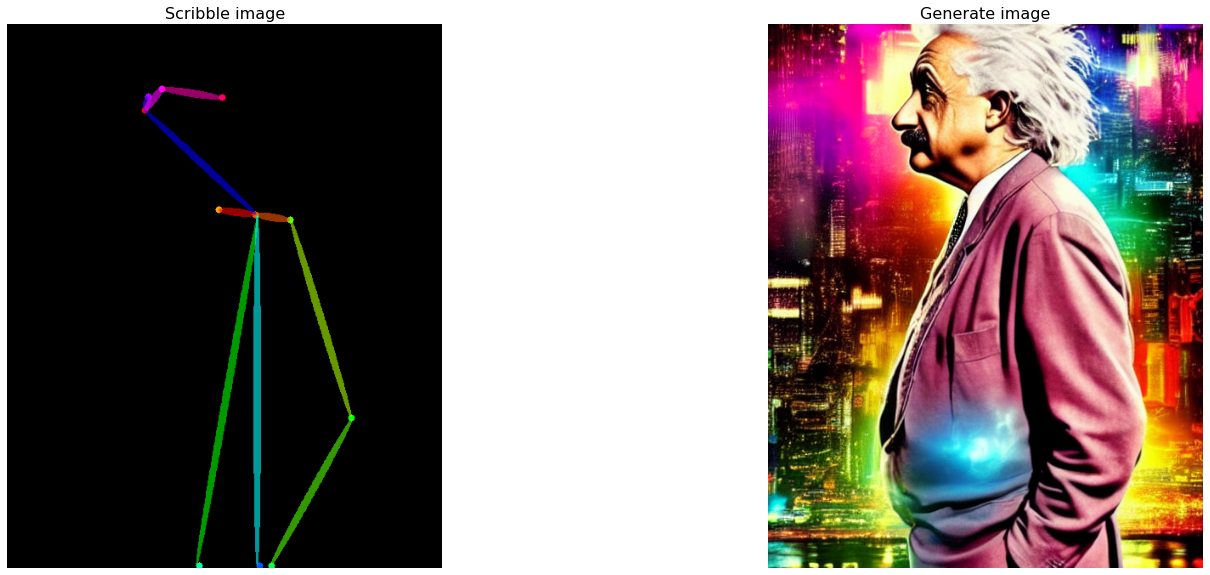

In [ ]:
#@title show images
src = PilImage.fromarray(np_imgs[0])
dst = PilImage.fromarray(np_imgs[1])

fig = plt.figure(figsize=(25, 10))

ax1 = fig.add_subplot(1, 2, 1)
plt.title('Scribble image', fontsize=16)
ax1.axis('off')
ax1.imshow(src)

ax2 = fig.add_subplot(1, 2, 2)
plt.title('Generate image', fontsize=16)
ax2.axis('off')
ax2.imshow(dst)

plt.show()

# DEMOS SCRIBBLE: let's do scribble on google colab

In [ ]:
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

In [ ]:
def draw(filename='drawing.png', w=512, h=512, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

In [ ]:
draw()

In [ ]:
img_path = 'drawing.png'
PilImage.open(img_path)

In [ ]:
prompt = 'Fansy cute girl, 4K, art' # @param {type:"string"}

In [ ]:
np_imgs = inference(img_path, prompt)

In [ ]:
src = PilImage.fromarray(np_imgs[0])
dst = PilImage.fromarray(np_imgs[1])

fig = plt.figure(figsize=(25, 10))

ax1 = fig.add_subplot(1, 2, 1)
plt.title('Scribble image', fontsize=16)
ax1.axis('off')
ax1.imshow(src)

ax2 = fig.add_subplot(1, 2, 2)
plt.title('Generate image', fontsize=16)
ax2.axis('off')
ax2.imshow(dst)

plt.show()